In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import re
from joblib import dump

# Load your dataset
df = pd.read_csv('S:\ML Course\Midterm Project 1\mobile_price.csv')

# Drop the 'Unnamed: 8' column that was showing up
if 'Unnamed: 8' in df.columns:
    df = df.drop('Unnamed: 8', axis=1)


    
len(df)


407

In [96]:
df.head()

,Brand,Model,Storage,RAM,Screen Size (inches),Camera (MP),Battery Capacity (mAh),Price ($)
0,Apple,iPhone 13 Pro,128 GB,6 GB,6.1,128,3095,999
1,Samsung,Galaxy S21 Ultra,256 GB,12 GB,6.8,256,5000,1199
2,OnePlus,9 Pro,128 GB,8 GB,6.7,128,4500,899
3,Xiaomi,Redmi Note 10 Pro,128 GB,6 GB,6.67,128,5020,279
4,Google,Pixel 6,128 GB,8 GB,6.4,128,4614,799


In [97]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')
df.head()


,brand,model,storage,ram,screen_size_(inches),camera_(mp),battery_capacity_(mah),price_($)
0,apple,iphone_13_pro,128_gb,6_gb,6.1,128,3095,999
1,samsung,galaxy_s21_ultra,256_gb,12_gb,6.8,256,5000,1199
2,oneplus,9_pro,128_gb,8_gb,6.7,128,4500,899
3,xiaomi,redmi_note_10_pro,128_gb,6_gb,6.67,128,5020,279
4,google,pixel_6,128_gb,8_gb,6.4,128,4614,799


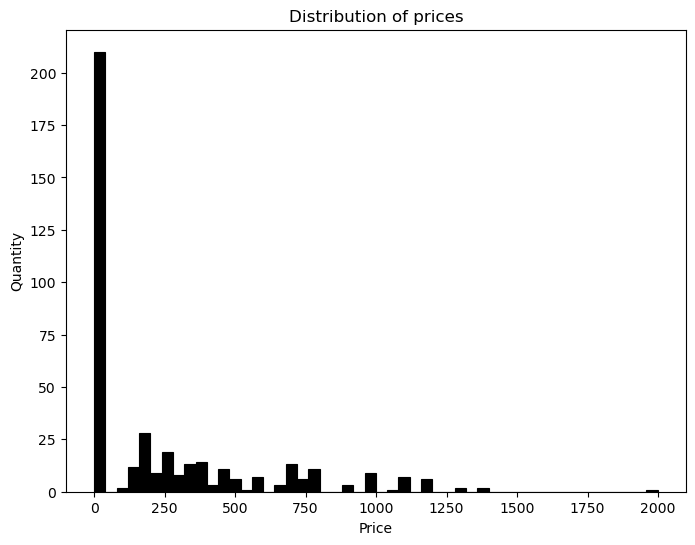

In [98]:
# Rename column price_($) to price
df.rename(columns={'price_($)':'price'}, inplace=True)

# Convert 'price' to numeric and handle any non-numeric entries.
df['price'] = pd.to_numeric(df['price'], errors='coerce').fillna(0)

# Handle NaN values that may have been introduced by non-numeric entries.
df['price'].fillna(df['price'].median(), inplace=True)

# Now you can safely log transform the price column.
df['log_price'] = np.log1p(df['price'])


plt.figure(figsize=(8, 6))

sns.histplot(df['price'], bins=50, color='black', alpha=1)
plt.ylabel('Quantity')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

In [99]:
df.isnull().sum()

brand                     0
model                     0
storage                   0
ram                       0
screen_size_(inches)      0
camera_(mp)               0
battery_capacity_(mah)    0
price                     0
log_price                 0
dtype: int64

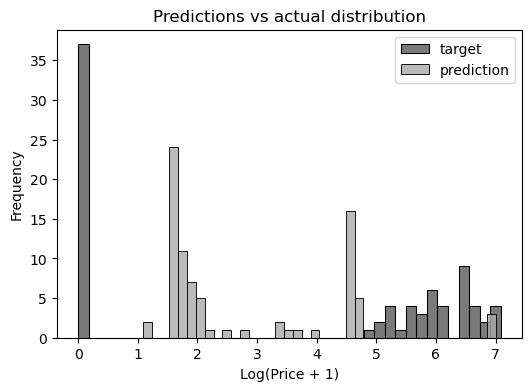

In [106]:
# Validation Framework
np.random.seed(2)
n = len(df)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(y_train_orig)
y_val = np.log1p(y_val_orig)
y_test = np.log1p(y_test_orig)

del df_train['price']
del df_val['price']
del df_test['price']

# Linear Regression Model Training
def train_linear_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

# Feature Preparation
base = ['storage', 'screen_size_(inches)', 'camera_(mp)']  # Make sure these are the correct feature names

def prepare_X(df):
    df_num = df.copy()
    for col in base:
        df_num[col] = pd.to_numeric(df_num[col], errors='coerce')
    df_num = df_num.fillna(0)
    X = df_num[base].values
    return X

# Prepare the data
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

# Train the model
model = train_linear_regression(X_train, y_train)

# Save the trained model
dump(model, 'model.joblib')

# Make predictions
y_pred = model.predict(X_val)

# Plot the predictions vs actual distribution
plt.figure(figsize=(6, 4))
sns.histplot(y_val, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')
plt.show()

In [115]:
from flask import Flask, request, jsonify
from joblib import load
from threading import Thread

app = Flask(__name__)

# Load the trained model
model = load('model.joblib')

@app.route('/')
def home():
    return "Welcome to the model prediction service!"

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    # Preprocess the input data as required, similar to how you did in the notebook
    # For example, if you expect a single feature called 'feature_input'
    input_data = [data['feature_input']]
    # Use the model to make a prediction
    prediction = model.predict([input_data])
    return jsonify({'prediction': prediction.tolist()})

# Define the function that will run the Flask app
def run_app():
    # Set the threaded argument to True to handle each request in a separate thread.
    app.run(port=6969, debug=True, use_reloader=False, threaded=True)

# Run the Flask app in a separate thread to avoid blocking the notebook
flask_thread = Thread(target=run_app)
flask_thread.start()


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:6969
Press CTRL+C to quit
127.0.0.1 - - [06/Nov/2023 21:40:14] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Nov/2023 21:40:14] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [06/Nov/2023 21:41:20] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Nov/2023 21:46:14] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Nov/2023 21:47:54] "GET / HTTP/1.1" 200 -


In [116]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [117]:
%pwd

'C:\\Users\\Detoxx'